<a href="https://colab.research.google.com/github/JulieOnIsland/Machine_Learning/blob/main/DACON_news_topic_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DACON 뉴스 토픽 분류 AI 경진대회
* https://dacon.io/competitions/official/235747/overview/description 
* LSTM 사용
* Accuracy: 84%
* Reference: https://wikidocs.net/44249

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Download and check the data

In [2]:
import pandas as pd
dpath = '/content/drive/MyDrive/data/dacon/news_topic_classification/'
train_df = pd.read_csv(dpath + 'train_data.csv')
train_df.head()

test_df = pd.read_csv(dpath + 'test_data.csv')
test_df.head()

,index,title
0,45654,유튜브 내달 2일까지 크리에이터 지원 공간 운영
1,45655,어버이날 맑다가 흐려져…남부지방 옅은 황사
2,45656,내년부터 국가RD 평가 때 논문건수는 반영 않는다
3,45657,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것
4,45658,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간


In [3]:
train_df.head()

,index,title,topic_idx
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4


In [4]:
!pip install konlpy

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [6]:
train_df.head()

,index,title,topic_idx
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4


In [7]:
len(train_df)

45654

In [8]:
train_df['title'].nunique()

45654

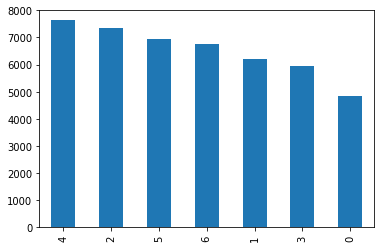

In [9]:
train_df['topic_idx'].value_counts().plot(kind='bar');

In [10]:
train_df.isnull().sum()

index        0
title        0
topic_idx    0
dtype: int64

In [11]:
train_df.loc[0]

index                               0
title        인천→핀란드 항공기 결항…휴가철 여행객 분통
topic_idx                           4
Name: 0, dtype: object

In [12]:
# 중복된 데이터 체크
train_df['title'].duplicated().sum()

0

# Preprocess the data

In [13]:
a_list=[]
for i in range(len(train_df)):
    if '…' in train_df['title'][i]:
        a_list.append(train_df.loc[i])


In [57]:
a_list[:5]

[index                               0
 title        인천→핀란드 항공기 결항…휴가철 여행객 분통
 topic_idx                           4
 Name: 0, dtype: object, index                                     1
 title        실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화
 topic_idx                                 4
 Name: 1, dtype: object, index                                       3
 title        NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합
 topic_idx                                   4
 Name: 3, dtype: object, index                                     6
 title        인도 48년 만에 파키스탄 공습…테러 캠프 폭격종합2보
 topic_idx                                 4
 Name: 6, dtype: object, index                                                7
 title        美대선 TV토론 음담패설 만회실패 트럼프…사과 대신 빌클린턴 공격해 역효과
 topic_idx                                            4
 Name: 7, dtype: object]

In [15]:
train_df['title'] = train_df['title'].str.replace('…', '')
train_df.head()

,index,title,topic_idx
0,0,인천→핀란드 항공기 결항휴가철 여행객 분통,4
1,1,실리콘밸리 넘어서겠다구글 15조원 들여 美전역 거점화,4
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,3,NYT 클린턴 측근韓기업 특수관계 조명공과 사 맞물려종합,4
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4


In [16]:
# KoNLPy에서 제공하는 형태소 분석기 Okt 사용
okt = Okt()

In [17]:
train_df['title'].loc[0]

'인천→핀란드 항공기 결항휴가철 여행객 분통'

In [18]:
okt.morphs(train_df['title'].loc[0], stem=True)

['인천', '→', '핀란드', '항공기', '결항', '휴가', '철', '여행객', '분통']

In [19]:
X_train = []
for sentence in tqdm(train_df['title']):
    tokenized_sentence = okt.morphs(sentence, stem=True)
    stopwords_removed_sentence = [word for word in tokenized_sentence]
    X_train.append(stopwords_removed_sentence)

100%|██████████| 45654/45654 [01:46<00:00, 426.77it/s]


In [20]:
print(X_train[:3])

[['인천', '→', '핀란드', '항공기', '결항', '휴가', '철', '여행객', '분통'], ['실리콘밸리', '넘어서다', '구글', '15조원', '들이다', '美', '전역', '거점', '화'], ['이란', '외무', '긴장', '완화', '해결', '책', '은', '미국', '이', '경제', '전쟁', '멈추다', '것']]


In [21]:
X_test = []
for sentence in tqdm(test_df['title']):
    tokenized_sentence = okt.morphs(sentence, stem=True)
    stopwords_removed_sentence = [word for word in tokenized_sentence]
    X_test.append(stopwords_removed_sentence)

100%|██████████| 9131/9131 [00:16<00:00, 560.41it/s]


In [22]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [23]:
# print(tokenizer.word_index)

In [24]:
total_cnt = len(tokenizer.word_index)
total_cnt

31130

In [25]:
vocab_size = total_cnt + 1

In [26]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [27]:
y_train=train_df['topic_idx'].to_numpy()
y_train

array([4, 4, 4, ..., 1, 2, 2])

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  stratify=y_train,
                                                  test_size=0.2)

In [29]:
print(y_train.shape, y_val.shape)

(36523,) (9131,)


In [30]:
X_train[:3]

[[336, 1, 2526, 1775, 94, 11, 242, 336, 2792, 1315, 4, 8, 37],
 [12951, 2064, 668, 9887, 1512, 2059, 8563, 2, 434, 1125, 299, 1140],
 [5213, 3527, 67, 2268, 1004, 247, 1, 12637]]

In [31]:
X_val[:3]

[[356, 1234, 991, 312, 26],
 [23, 48, 2757, 567, 23, 219, 40, 16, 219, 14, 3871, 860, 15618],
 [22, 403, 467, 67, 1292, 944, 2794, 4013, 1293, 11, 61, 1425, 4]]

In [32]:
len_list=[]
for i in range(len(X_train)):
    len_list.append(len(X_train[i]))

In [33]:
max(len_list)

21

In [34]:
val_len_list=[]
for i in range(len(X_val)):
    val_len_list.append(len(X_val[i]))

In [35]:
max(val_len_list)

21

In [36]:
max_len=21

In [37]:
test_len_list=[]
for i in range(len(X_test)):
    test_len_list.append(len(X_test[i]))

In [38]:
max(test_len_list)

19

In [39]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_val = pad_sequences(X_val, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [40]:
vocab_size

31131

In [41]:
train_df['topic_idx'].unique()

array([4, 6, 5, 0, 1, 3, 2])

# Build the model

In [42]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(7, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=2, save_best_only=True)

model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=5, callbacks=[es, mc], batch_size=64, 
                    validation_data=(X_val, y_val))

Epoch 1/5
570/571 [============================>.] - ETA: 0s - loss: 0.7680 - acc: 0.7320
Epoch 1: val_acc improved from -inf to 0.83846, saving model to best_model.h5
571/571 [==============================] - 13s 16ms/step - loss: 0.7680 - acc: 0.7320 - val_loss: 0.4776 - val_acc: 0.8385
Epoch 2/5
569/571 [============================>.] - ETA: 0s - loss: 0.2751 - acc: 0.9113
Epoch 2: val_acc improved from 0.83846 to 0.84449, saving model to best_model.h5
571/571 [==============================] - 8s 13ms/step - loss: 0.2749 - acc: 0.9114 - val_loss: 0.4692 - val_acc: 0.8445
Epoch 3/5
571/571 [==============================] - ETA: 0s - loss: 0.1526 - acc: 0.9504
Epoch 3: val_acc did not improve from 0.84449
571/571 [==============================] - 7s 13ms/step - loss: 0.1526 - acc: 0.9504 - val_loss: 0.5879 - val_acc: 0.8344
Epoch 4/5
569/571 [============================>.] - ETA: 0s - loss: 0.0947 - acc: 0.9691
Epoch 4: val_acc did not improve from 0.84449
571/571 [=============

In [43]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_val, y_val)[1]))

286/286 [==============================] - 2s 5ms/step - loss: 0.4692 - acc: 0.8445

 테스트 정확도: 0.8445


In [44]:
preds=loaded_model.predict(X_test)
preds[:5]

array([[7.8688383e-02, 7.2098011e-03, 1.6144761e-01, 7.4020791e-01,
        4.5825075e-03, 8.4124517e-04, 7.0225717e-03],
       [3.9478598e-04, 2.4037449e-04, 9.4409450e-04, 9.9790657e-01,
        1.9351803e-04, 2.5860014e-04, 6.2134262e-05],
       [1.3295305e-02, 2.7095480e-02, 7.3181665e-01, 7.5995135e-03,
        8.9091389e-03, 2.8542103e-03, 2.0842966e-01],
       [5.5780336e-02, 2.6774490e-02, 9.0133357e-01, 5.6974017e-03,
        5.4241940e-03, 9.4868388e-04, 4.0413253e-03],
       [1.4142706e-05, 1.5329298e-06, 3.8991158e-04, 9.9958783e-01,
        1.0878126e-06, 1.8382846e-06, 3.6487529e-06]], dtype=float32)

In [45]:
len(preds)

9131

In [46]:
len(test_df)

9131

In [47]:
preds[0].argmax()

3

In [48]:
total_preds=np.argmax(preds, axis=1)

In [49]:
total_preds

array([3, 3, 2, ..., 3, 0, 6])

## Submission

In [50]:
submission = pd.read_csv('/content/drive/MyDrive/data/dacon/news_topic_classification/sample_submission.csv')

In [51]:
path = '/content/drive/MyDrive/data/dacon/news_topic_classification/sample_submission.csv'

In [52]:
submission.head()

,index,topic_idx
0,45654,3
1,45655,3
2,45656,2
3,45657,0
4,45658,3


In [53]:
submission.topic_idx = total_preds

In [54]:
submission.head()

,index,topic_idx
0,45654,3
1,45655,3
2,45656,2
3,45657,2
4,45658,3


In [55]:
submission

,index,topic_idx
0,45654,3
1,45655,3
2,45656,2
3,45657,2
4,45658,3
...,...,...
9126,54780,3
9127,54781,2
9128,54782,3
9129,54783,0


In [56]:
submission.to_csv(path, index=False)

# The END